<a href="https://colab.research.google.com/github/Ainmaxx/PVmodel_v1/blob/main/Model_Forecast_PV_Output_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Forecast PV Output

Mount file from drive 1

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
print(tf.__version__)

2.8.0


In [ ]:
!pip install tensorflowjs

# Visualization time series


In [4]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time/Date")
    plt.ylabel("Value/PV Output(kWh/kWp)")
    plt.grid(True)

# Model in Time Series

In [ ]:
#!wget --no-check-certificate \
    #https://github.com/Ainmaxx/PVmodel_v1/daily-output-pv.csv

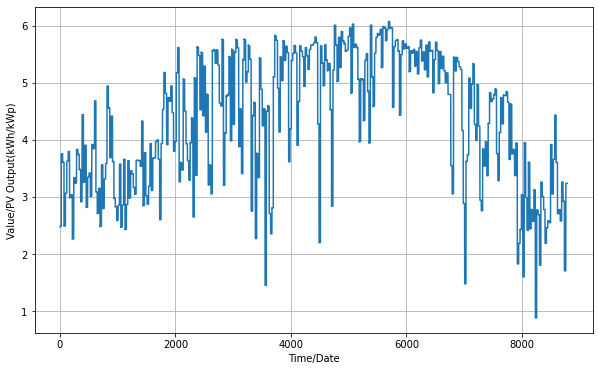

In [5]:
import csv
time_step = []
outputpv = []

with open('/content/drive/MyDrive/Colab Notebooks/data/daily-output PV.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    outputpv.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(outputpv)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

split_time = 2000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

Model Prediction

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])
#lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(2000,)
Epoch 1/100
8/8 [==============================] - 15s 68ms/step - loss: 3.2972 - mae: 3.7732
Epoch 2/100
8/8 [==============================] - 0s 34ms/step - loss: 1.8271 - mae: 2.2812
Epoch 3/100
8/8 [==============================] - 0s 29ms/step - loss: 1.0189 - mae: 1.4290
Epoch 4/100
8/8 [==============================] - 0s 31ms/step - loss: 1.2109 - mae: 1.6471
Epoch 5/100
8/8 [==============================] - 0s 29ms/step - loss: 1.1855 - mae: 1.6198
Epoch 6/100
8/8 [==============================] - 0s 30ms/step - loss: 1.1241 - mae: 1.5629
Epoch 7/100
8/8 [==============================] - 0s 28ms/step - loss: 0.9356 - mae: 1.3452
Epoch 8/100
8/8 [==============================] - 0s 27ms/step - loss: 1.0188 - mae: 1.4673
Epoch 9/100
8/8 [==============================] - 0s 31ms/step - loss: 0.8948 - mae: 1

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          192       
                                                                 
 lstm (LSTM)                 (None, None, 64)          24832     
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          33024     
                                                                 
 dense (Dense)               (None, None, 30)          1950      
                                                                 
 dense_1 (Dense)             (None, None, 10)          310       
                                                                 
 dense_2 (Dense)             (None, None, 1)           11        
                                                                 
 lambda (Lambda)             (None, None, 1)           0

In [9]:
#plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-4, 0, 20])

RNN Forecasting

In [10]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

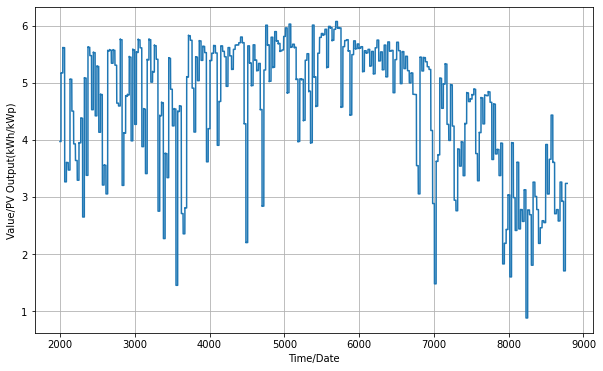

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


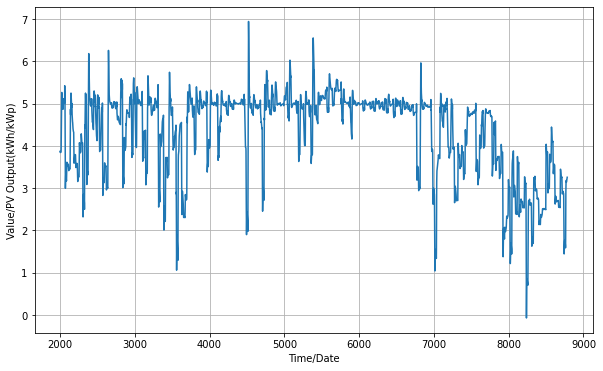

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, rnn_forecast)

Output MAE

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.36777624

In [14]:
print(rnn_forecast)

[3.871122  3.8625062 3.8553224 ... 3.2396026 3.250453  3.2592318]


# Saved Model Json Format
save model to HDF5 file and convert to json

In [ ]:
saved_model_path = "./my_model.h5"
model.save(saved_model_path)

In [ ]:
!tensorflowjs_converter --input_format=keras /content/my_model.h5 ./

# Exporting to TFLite


In [ ]:
export_dir = 'saved_model/ML'
tf.saved_model.save(model, export_dir)

In [ ]:
optimization = tf.lite.Optimize.DEFAULT
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [optimization]
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)